## IMDb

At Fast.ai we have introduced a new module called fastai.text which replaces the torchtext library that was used in our 2018 dl1 course. The fastai.text module also supersedes the fastai.nlp library but retains many of the key functions.

In [1]:
from fastai.text import *
import html

The Fastai.text module introduces several custom tokens.

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/
Direct link : [Link](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

**===================================== (START) Download IMDb data =====================================**

In [6]:
%mkdir data/aclImdb
%cd data/aclImdb

/home/ubuntu/data/aclImdb


In [8]:
!aria2c --file-allocation=none -c -x 5 -s 5 http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

[#6acf06 79MiB/80MiB(99%) CN:1 DL:14MiB]                          
06/26 15:59:49 [NOTICE] Download complete: /home/ubuntu/data/aclImdb/aclImdb_v1.tar.gz

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
6acf06|OK  |    14MiB/s|/home/ubuntu/data/aclImdb/aclImdb_v1.tar.gz

Status Legend:
(OK):download completed.


In [10]:
!tar -zxf aclImdb_v1.tar.gz -C .

In [16]:
%cd ../..
%rm data/aclImdb/aclImdb_v1.tar.gz

/home/ubuntu


In [22]:
%mv data/aclImdb/ data/aclImdb2

In [24]:
%mv data/aclImdb2/aclImdb data/

In [29]:
%rm -rf data/aclImdb2

In [2]:
PATH = Path('data/aclImdb/')

In [55]:
!ls -lah {PATH}

total 1.7M
drwxr-xr-x 4 ubuntu ubuntu 4.0K Jun 26  2011 .
drwxrwxr-x 8 ubuntu ubuntu 4.0K Jun 26 16:17 ..
-rw-r--r-- 1 ubuntu ubuntu 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 ubuntu ubuntu 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 ubuntu ubuntu 4.0K Jun 26  2011 README
drwxr-xr-x 4 ubuntu ubuntu 4.0K Jun 26 16:02 test
drwxr-xr-x 5 ubuntu ubuntu 4.0K Jun 26 16:02 train


**===================================== (END) Download IMDb data =====================================**

In [3]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

## Standardize format

In [4]:
CLAS_PATH = Path('data/imdb_clas/')
CLAS_PATH.mkdir(exist_ok=True)

In [38]:
!ls data

aclImdb  dogscats  dogscats.zip  imdb_clas  pascal  spellbee


In [5]:
LM_PATH = Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

In [3]:
!ls data

aclImdb  dogscats  dogscats.zip  imdb_clas  imdb_lm  pascal  spellbee


The IMDb dataset has 3 classes; positive, negative and unsupervised(sentiment is unknown).
There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup)
There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup)

Refer to the README file in the IMDb corpus for further information about the dataset.

In [43]:
!cat data/aclImdb/README

Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movie-unique terms and their associated with observed labels.  In the
labeled train/test sets, a negative review has a score <= 4 out of 10,
and a positive review has a scor

In [6]:
CLASSES = ['neg', 'pos', 'unsup']

In [7]:
def get_texts(path):
    texts, labels = [], []
    
    for idx, label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            texts.append(fname.open('r').read())
            labels.append(idx)
    return np.array(texts), np.array(labels)

In [8]:
trn_texts, trn_labels = get_texts(PATH / 'train')
val_texts, val_labels = get_texts(PATH / 'test')

In [9]:
len(trn_texts), len(val_texts)

(75000, 25000)

In [10]:
col_names = ['labels', 'text']

We use a random permutation numpy array to shuffle the text reviews.

In [11]:
np.random.seed(42)
trn_idx = np.random.permutation(len(trn_texts))
val_idx = np.random.permutation(len(val_texts))

In [12]:
trn_texts = trn_texts[trn_idx]
val_texts = val_texts[val_idx]

trn_labels = trn_labels[trn_idx]
val_labels = val_labels[val_idx]

In [13]:
df_trn = pd.DataFrame({ 'text': trn_texts, 'labels': trn_labels }, columns=col_names)
df_val = pd.DataFrame({ 'text': val_texts, 'labels': val_labels }, columns=col_names)

In [14]:
# DEBUG
# View train df
df_trn.head()

,labels,text
0,2,A group of filmmakers (College Students?) deci...
1,0,Sequels have a nasty habit of being disappoint...
2,1,"In a future society, the military component do..."
3,2,"Imagine Albert Finney, one of the great ham bo..."
4,2,I bought this DVD for $2.00 at the local varie...


In [15]:
# DEBUG
# View validation df
df_val.head()

,labels,text
0,1,Every year there's one can't-miss much-anticip...
1,1,I don't usually like this sort of movie but wa...
2,1,Great movie in a Trainspotting style... Being ...
3,0,New rule. Nobody is allowed to make any more Z...
4,0,I saw this movie (unfortunately) because it wa...


The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column.

In [28]:
# we remove everything that has a label of 2 `df_trn['labels'] != 2` because label of 2 is "unsupervised" and we can’t use it.
df_trn[df_trn['labels'] != 2].to_csv(CLAS_PATH / 'train.csv', header=False, index=False)

df_val.to_csv(CLAS_PATH / 'test.csv', header=False, index=False)

(CLAS_PATH / 'classes.txt').open('w').writelines(f'{o}\n' for o in CLASSES)

We start by creating the data for the Language Model(LM). The LM's goal is to learn the structure of the English language. It learns language by trying to predict the next word given a set of previous words(ngrams). Since the LM does not classify reviews, the labels can be ignored.

The LM can benefit from all the textual data and there is no need to exclude the unsup/unclassified movie reviews.

We first concat all the train(pos/neg/unsup = **75k**) and test(pos/neg=**25k**) reviews into a big chunk of **100k** reviews. And then we use sklearn splitter to divide up the 100k texts into 90% training and 10% validation sets.

In [16]:
trn_texts, val_texts = sklearn.model_selection.train_test_split(
    np.concatenate([trn_texts, val_texts]), test_size=0.1)

In [17]:
len(trn_texts), len(val_texts)

(90000, 10000)

In [18]:
df_trn = pd.DataFrame({ 'text': trn_texts, 'labels': [0] * len(trn_texts) }, columns=col_names)
df_val = pd.DataFrame({ 'text': val_texts, 'labels': [0] * len(val_texts) }, columns=col_names)

df_trn.to_csv(LM_PATH / 'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH / 'test.csv', header=False, index=False)

## Language model tokens

In this section, we start cleaning up the messy text. There are 2 main activities we need to perform:

1. Clean up extra spaces, tab chars, new line chars and other characters and replace them with standard ones.
2. Use the awesome [spaCy](http://spacy.io) library to tokenize the data. Since spaCy does not provide a parallel/multicore version of the tokenizer, the fastai library adds this functionality. This parallel version uses all the cores of your CPUs and runs much faster than the serial version of the spacy tokenizer.

Tokenization is the process of splitting the text into separate tokens so that each token can be assigned a unique index. This means we can convert the text into integer indexes our models can use.

We use an appropriate `chunksize` as the tokenization process is memory intensive.

### Tokenize

In [19]:
chunksize = 24000

Before we pass it to spaCy, we will write a simple fixup function which is each time we have looked at different datasets (about a dozen in building this), every one had different weird things that needed to be replaced. So here are all the ones we have come up with so far, and hopefully this will help you out as well. All the entities are HTML unescaped and there are bunch more things we replace. Have a look at the result of running this on text that you put in and make sure there's no more weird tokens in there.

In [20]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

In [21]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:, range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls + 1, len(df.columns)):
        texts += f' {FLD} {i - n_lbls} ' + df[i].astype(str)
    texts = texts.apply(fixup).values.astype(str)
    
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [22]:
def get_all(df, n_lbls):
    tok, labels = [], []
    
    for i, r in enumerate(df):
        print(i)
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_
        labels += labels_
    return tok, labels

In [23]:
df_trn = pd.read_csv(LM_PATH / 'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(LM_PATH / 'test.csv', header=None, chunksize=chunksize)

In [51]:
# tok_trn, trn_labels = get_all(df_trn, 1)
# tok_val, val_labels = get_all(df_val, 1)

0


OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.

Fix spaCy issue above:

In [52]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 81.7MB/s ta 0:00:01  7% |██▎                             | 2.6MB 611kB/s eta 0:00:57
  Running setup.py install for en-core-web-sm ... done
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.

    Linking successful
    /home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/en_core_web_sm
    -->
    /home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



In [24]:
# Re-run these 2 lines of codes.
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
1
2
3
0


In [54]:
(LM_PATH / 'tmp').mkdir(exist_ok=True)

**Testing**

In [25]:
type(tok_trn), len(tok_trn)

(list, 90000)

In [26]:
tok_trn[0]

['\n',
 'xbos',
 'xfld',
 '1',
 'first',
 'of',
 'all',
 'jan',
 'guillou',
 'is',
 'a',
 'fantastic',
 'writer',
 '.',
 'but',
 'even',
 'so',
 ',',
 'i',
 'have',
 'not',
 'read',
 'his',
 '"',
 'arn',
 '"-',
 'series',
 'books',
 '.',
 'as',
 'i',
 'have',
 'great',
 'love',
 'and',
 'respect',
 'for',
 'guillou',
 ',',
 'i',
 'had',
 'high',
 'expectations',
 'for',
 'this',
 'movie',
 '.',
 'also',
 ',',
 'a',
 'good',
 'friend',
 'of',
 'mine',
 '(',
 'student',
 'in',
 'university',
 'reading',
 'history',
 ')',
 'had',
 'read',
 'and',
 'recommended',
 'this',
 'book',
 'strongly',
 '.',
 'perhaps',
 'the',
 'director',
 'could',
 "n't",
 'catch',
 'the',
 'atmosphere',
 'in',
 'the',
 'book',
 ',',
 'because',
 'the',
 'movie',
 'was',
 'a',
 'huge',
 'disappointment',
 '.',
 'so',
 'i',
 'will',
 'go',
 'very',
 'hard',
 'on',
 'this',
 't_up',
 'movie',
 'and',
 'not',
 'on',
 'the',
 'book',
 'so',
 'please',
 'make',
 'the',
 'difference',
 '.',
 '\n\n',
 'arn',
 ',',
 'mo

In [27]:
type(trn_labels), len(trn_labels)

(list, 90000)

Tokenization Result

Beginning of the stream token (`xbos`), beginning of field number 1 token (`xfld 1`), and tokenized text. You'll see that the punctuation is on whole now a separate token.

In [28]:
' '.join(tok_trn[0])

'\n xbos xfld 1 first of all jan guillou is a fantastic writer . but even so , i have not read his " arn "- series books . as i have great love and respect for guillou , i had high expectations for this movie . also , a good friend of mine ( student in university reading history ) had read and recommended this book strongly . perhaps the director could n\'t catch the atmosphere in the book , because the movie was a huge disappointment . so i will go very hard on this t_up movie and not on the book so please make the difference . \n\n arn , movie , tells us the tale of arn , born in 1150 , in the north of europe , in what would later become today \'s sweden . the movie is basically separated in three parts ; ( 1 ) rise of sweden , meaning the rivals and fights for land and kingdom , ( 2 ) arns own tale , ( 3 ) a romantic . i do n\'t want to tell more than that about the movie , but now on the trailers you see a lot of wars in jerusalem , but that is only very short time of this 2.31 hou

In [29]:
' '.join(tok_trn[1])

"\n xbos xfld 1 for lack of better things to watch , we stumbled on this movie the other night on cable . wow ! if action is your thing , this film will be for you . there must be killings every five minutes . in fact , we are worried when there are no shootings in the background ! \n\n charles t. kanganis wrote and directed this movie that has a woman detective at the center of the story . vickie , is a tough cookie ( no pun intended ) . she might look blonde and vulnerable , but just do n't mess around with her . the fact that vickie is basically standing up as the film ends is a testament to tracy lords ' masochism . \n\n the bad guys come and go , yet , vickie is able to avoid being shot , or have her hair messed during the worst of the action . the action is too intense at times as the latin gangsters show to be ruthless in the way they settle disputes . \n\n watch this film for the pure fun of watching the action . otherwise , do n't bother ."

**Save work**

In [30]:
np.save(LM_PATH / 'tmp' / 'tok_trn.npy', tok_trn)
np.save(LM_PATH / 'tmp' / 'tok_val.npy', tok_val)

In [31]:
# Try to load it back up later
tok_trn = np.load(LM_PATH / 'tmp' / 'tok_trn.npy')
tok_val = np.load(LM_PATH / 'tmp' / 'tok_val.npy')

In [32]:
# DEBUG - check serialized numpy files are created
!ls -lh {LM_PATH}/tmp

total 381M
-rw-rw-r-- 1 ubuntu ubuntu 1010K Jun 27 15:42 itos.pkl
-rw-rw-r-- 1 ubuntu ubuntu  299M Jun 28 07:30 tok_trn.npy
-rw-rw-r-- 1 ubuntu ubuntu   34M Jun 28 07:30 tok_val.npy
-rw-rw-r-- 1 ubuntu ubuntu   42M Jun 27 15:42 trn_ids.npy
-rw-rw-r-- 1 ubuntu ubuntu  6.3M Jun 27 15:42 val_ids.npy


### Numericalize

Now that we got it tokenized, the next thing we need to do is to turn it into numbers which we call numericalizing it.

In [33]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('the', 1209252),
 ('.', 993276),
 (',', 984626),
 ('and', 587546),
 ('a', 584199),
 ('of', 524706),
 ('to', 485996),
 ('is', 394082),
 ('it', 341931),
 ('in', 337846),
 ('i', 308713),
 ('this', 270873),
 ('that', 261496),
 ('"', 237503),
 ("'s", 221557),
 ('-', 187727),
 ('was', 180500),
 ('\n\n', 179162),
 ('as', 166379),
 ('with', 159369),
 ('for', 159204),
 ('movie', 157938),
 ('but', 150477),
 ('film', 144038),
 ('you', 124418)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set `max_vocab` to 60000.

In [34]:
max_vocab = 60000
min_freq = 1

In [35]:
itos = [o for o, c in freq.most_common(max_vocab) if c > min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [36]:
len(itos)

60002

We create a reverse mapping called `stoi` which is useful to lookup the index of a given token. `stoi` also has the same number of elements as `itos`. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our `stoi` mapping.

In [37]:
stoi = collections.defaultdict(lambda: 0, { v: k for k, v in enumerate(itos) })
len(itos)

60002

In [38]:
trn_lm = np.array([ [stoi[o] for o in p] for p in tok_trn ])
val_lm = np.array([ [stoi[o] for o in p] for p in tok_val ])

**Testing**

In [39]:
' '.join(str(o) for o in trn_lm[0])

'40 41 42 39 106 7 43 5033 36163 9 6 846 569 3 24 75 51 4 12 36 32 369 35 15 18231 5213 228 1218 3 20 12 36 101 131 5 1166 22 36163 4 12 84 323 1413 22 13 23 3 102 4 6 66 443 7 1805 30 1374 11 3458 901 499 27 84 369 5 1169 13 309 2337 3 400 2 169 95 29 1323 2 879 11 2 309 4 105 2 23 18 6 672 1459 3 51 12 104 158 69 266 28 13 31 23 5 32 28 2 309 51 617 112 2 1540 3 19 18231 4 23 4 716 200 2 777 7 18231 4 1362 11 0 4 11 2 2135 7 2258 4 11 63 72 329 445 511 16 7852 3 2 23 9 681 5744 11 300 522 133 30 39 27 2240 7 7852 4 1201 2 6910 5 1758 22 1300 5 4683 4 30 261 27 58729 221 777 4 30 381 27 6 745 3 12 57 29 201 8 401 67 92 14 58 2 23 4 24 166 28 2 4351 26 83 6 186 7 1610 11 16640 4 24 14 9 81 69 365 74 7 13 0 562 216 23 3 640 31 136 123 31 428 2 170 85 115 116 1864 7 14 13 18 6 3630 2673 4 5 68 45 275 78 6284 4 38 95 83 47 43 8 7992 30 32 593 103 78 120 27 170 3 136 18 51 357 4 12 557 3661 133 62 13 31 18 6 658 603 23 3 45 85 660 78 428 20 6 417 593 11 19313 72 57 11 4216 4 79 18 56 82 87

**Save work**

In [40]:
np.save(LM_PATH / 'tmp' / 'trn_ids.npy', trn_lm)
np.save(LM_PATH / 'tmp' / 'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH / 'tmp' / 'itos.pkl', 'wb'))

In [41]:
trn_lm = np.load(LM_PATH / 'tmp' / 'trn_ids.npy')
val_lm = np.load(LM_PATH / 'tmp' / 'val_ids.npy')
itos = pickle.load(open(LM_PATH / 'tmp' / 'itos.pkl', 'rb'))

In [42]:
vs = len(itos)
vs, len(trn_lm)

(60002, 90000)

## Pre-training

### WikiText-103 conversion

We are now going to build an English language model (LM) for the IMDb corpus. We could start from scratch and try to learn the structure of the English language. But we use a technique called transfer learning to make this process easier. In transfer learning (a fairly recent idea for NLP) a pre-trained LM that has been trained on a large generic corpus(_like wikipedia articles_) can be used to transfer it's knowledge to a target LM and the weights can be fine-tuned.

Our source LM is the WikiText-103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/)
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the IMDb LM.

In [123]:
# wget options:
# -nH don't create host directories
# -r specify recursive download
# -np don't ascend to the parent directory
# -P get all images, etc. needed to display HTML page
!wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

--2018-06-28 04:49:15--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/aclImdb/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-06-28 04:49:16 (140 MB/s) - ‘data/aclImdb/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-06-28 04:49:16--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-06-28 04:49:16 ERROR 404: Not Found.

--2018-06-28 04:49:16--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/aclImdb/models/wt103/index.html?C=N;O=D’

models/wt103/index. 100

In [163]:
!ls -lh {PATH}/models/wt103

total 1.8G
-rw-rw-r-- 1 ubuntu ubuntu 441M Mar 29 00:31 bwd_wt103_enc.h5
-rw-rw-r-- 1 ubuntu ubuntu 441M Mar 29 00:34 bwd_wt103.h5
-rw-rw-r-- 1 ubuntu ubuntu 441M Mar 29 00:36 fwd_wt103_enc.h5
-rw-rw-r-- 1 ubuntu ubuntu 441M Mar 29 00:39 fwd_wt103.h5
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:49 index.html
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:49 index.html?C=D;O=A
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:53 index.html?C=D;O=D
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:49 index.html?C=M;O=A
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:53 index.html?C=M;O=D
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:53 index.html?C=N;O=A
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:49 index.html?C=N;O=D
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:49 index.html?C=S;O=A
-rw-rw-r-- 1 ubuntu ubuntu  857 Jun 28 04:53 index.html?C=S;O=D
-rw-rw-r-- 1 ubuntu ubuntu 4.0M Mar 29 00:30 itos_wt103.pkl


The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [43]:
em_sz, nh, nl = 400, 1150, 3

Here are our pre-trained path and our pre-trained language model path.

In [44]:
PRE_PATH = PATH / 'models' / 'wt103'
PRE_LM_PATH = PRE_PATH / 'fwd_wt103.h5'

In [45]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

**Map IMDb vocab to WikiText vocab**

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [46]:
# ==================================== START DEBUG ====================================

# specialized container datatypes providing alternatives to Python’s general purpose built-in containers, dict.
# dict subclass that remembers the order entries were added.

# In other words,
# a regular dict does not track the insertion order, and iterating over it produces the values in an arbitrary order.
# In an OrderedDict, by contrast, the order the items are inserted is remembered and used when creating an iterator.
print(type(wgts))

print(len(wgts))
for k in wgts.keys():
    print(k)

tmp_wgts = wgts['0.encoder.weight']
print(f'\n{type(tmp_wgts)}' )

tmp_enc_wgts = to_np(tmp_wgts)
print( type(to_np(tmp_wgts)) )

# pre-trained LM weights have an embedding size of 400
print( tmp_enc_wgts.shape )

tmp_row_m = tmp_enc_wgts.mean(0) # returns the average of the array elements along axis 0
print( type(tmp_row_m) ) # numpy.ndarray
print( tmp_row_m.shape ) # shape: (400,)

# ==================================== END DEBUG ====================================

<class 'collections.OrderedDict'>
15
0.encoder.weight
0.encoder_with_dropout.embed.weight
0.rnns.0.module.weight_ih_l0
0.rnns.0.module.bias_ih_l0
0.rnns.0.module.bias_hh_l0
0.rnns.0.module.weight_hh_l0_raw
0.rnns.1.module.weight_ih_l0
0.rnns.1.module.bias_ih_l0
0.rnns.1.module.bias_hh_l0
0.rnns.1.module.weight_hh_l0_raw
0.rnns.2.module.weight_ih_l0
0.rnns.2.module.bias_ih_l0
0.rnns.2.module.bias_hh_l0
0.rnns.2.module.weight_hh_l0_raw
1.decoder.weight

<class 'torch.FloatTensor'>
<class 'numpy.ndarray'>
(238462, 400)
<class 'numpy.ndarray'>
(400,)


In [47]:
enc_wgts = to_np(wgts['0.encoder.weight']) # converts np.ndarray from torch.FloatTensor.output shape: (238462, 400)
row_m = enc_wgts.mean(0) # returns the average of the array elements along axis 0. output shape: (400,)

In [48]:
itos2 = pickle.load( (PRE_PATH / 'itos_wt103.pkl').open('rb') )
stoi2 = collections.defaultdict(lambda: -1, { v: k for k, v in enumerate(itos2) })

In [49]:
# ==================================== START DEBUG ====================================

print( type(itos2) )
print(len(itos2))

i = 0
for k, v in enumerate(itos2):
    i = i + 1
    if i <= 10:
        print(f'{k}: {v}')
    else:
        break

print( type(stoi2) )
print( len(stoi2) )
print( stoi2['On'] ) # returns -1 (because the vocab is not found)
print( stoi2['the'] ) # returns 2

# ==================================== END DEBUG ====================================

<class 'list'>
238462
0: _unk_
1: _pad_
2: the
3: ,
4: .
5: of
6: and
7: in
8: to
9: a
<class 'collections.defaultdict'>
238462
-1
2


Before we try to transfer the knowledge from WikiText to the IMDb LM, we match up the vocab words and their indexes. We use the `defaultdict` container once again, to assign mean weights to unknown IMDb tokens that do not exist in WikiText-103.

In [50]:
new_w = np.zeros((vs, em_sz), dtype=np.float32) # shape: (60002, 400)

for i, w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r >= 0 else row_m

We now overwrite the weights into the `wgts` OrderedDict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [52]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w)) # weird thing with how we do embedding dropout
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDb language PyTorch model!

## Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDb LM pre-trained with WikiText and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (*also known traditionally in NLP LM as ngrams*) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness. 

Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch size is constant but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to [Smerity](https://twitter.com/jeremyphoward/status/980227258395770882))

In [53]:
wd = 1e-7
bptt = 70
bs = 52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the `LanguageModelLoader` to create a data loader which makes it easy to create and use bptt sized mini batches. The  `LanguageModelLoader` takes a concatenated string of tokens and returns a loader.

We have a special modeldata object class for LMs called `LanguageModelData` to which we can pass the training and validation loaders and get in return the model itself.

In [54]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

**Choosing dropout**

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (`0.7` here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. *No other dropout value requires tuning*.

In [56]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15]) * 0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [57]:
learner = md.get_model(opt_fn, em_sz, nh, nl,
                       dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

**Measuring accuracy**

In [58]:
learner.model.load_state_dict(wgts)

We set learning rates and fit our IMDb LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the WikiText-103 learn better weights.

In [59]:
lr = 1e-3
lrs = lr

In [60]:
learner.fit(lrs / 2, 1, wds=wd, use_clr=(32, 2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                       
    0      4.663849   4.442456   0.258212  



[array([4.44246]), 0.2582116474118943]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [61]:
learner.save('lm_last_ft')

In [62]:
learner.load('lm_last_ft')

In [63]:
learner.unfreeze()

In [64]:
learner.lr_find(start_lr=lrs / 10, end_lr=lrs * 10, linear=True)

epoch      trn_loss   val_loss   accuracy                       
    0      4.743739   4.586191   0.247705  



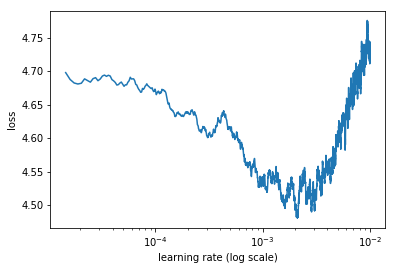

In [65]:
learner.sched.plot()

In [67]:
learner.fit(lrs, 1, wds=wd, use_clr=(20, 10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                       
    0      4.133916   4.017627   0.300258  
    1      4.127663   4.023184   0.299315                       
 70%|███████   | 4818/6872 [57:53<24:40,  1.39it/s, loss=4.14]  

KeyboardInterrupt: 

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [68]:
learner.save('lm1')

In [69]:
learner.save_encoder('lm1_enc')

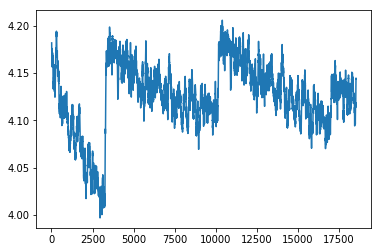

In [70]:
learner.sched.plot_loss()

## Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.

In [ ]:
df_trn = pd.read_csv(CLAS_PATH / 'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH /'test.csv', header=None, chunksize=chunksize)

In [ ]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

In [ ]:
(CLAS_PATH / 'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH / 'tmp' / 'tok_trn.npy', tok_trn)
np.save(CLAS_PATH /'tmp' / 'tok_val.npy', tok_val)

np.save(CLAS_PATH /'tmp' / 'trn_labels.npy', trn_labels)
np.save(CLAS_PATH /'tmp' / 'val_labels.npy', val_labels)

In [ ]:
tok_trn = np.load(CLAS_PATH / 'tmp' / 'tok_trn.npy')
tok_val = np.load(CLAS_PATH / 'tmp' / 'tok_val.npy')

In [ ]:
itos = pickle.load((LM_PATH / 'tmp' / 'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda: 0, { v: k for k, v in enumerate(itos) })
len(itos)

In [ ]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [ ]:
np.save(CLAS_PATH / 'tmp' / 'trn_ids.npy', trn_clas)
np.save(CLAS_PATH / 'tmp' / 'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDb backbone. The steps to create the classifier model are similar to the ones for the LM.

In [ ]:
trn_clas = np.load(CLAS_PATH / 'tmp' / 'trn_ids.npy')
val_clas = np.load(CLAS_PATH / 'tmp' / 'val_ids.npy')

In [ ]:
trn_labels = np.squeeze(np.load(CLAS_PATH / 'tmp' / 'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH / 'tmp' / 'val_labels.npy'))

In [ ]:
bptt, em_sz, nh, nl = 70, 400, 1150, 3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [ ]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c = int(trn_labels.max()) + 1

**Shuffle documents; Sort-ish to save computation**

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict its sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by [@Smerity](https://twitter.com/Smerity) and [@jekbradbury](https://twitter.com/jekbradbury)

The `SortishSampler` cuts down the overall number of padding tokens the classifier ends up seeing.

In [ ]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)

**Turning it to DataLoader**

In [ ]:
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs // 2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))

In [ ]:
trn_dl = DataLoader(trn_ds, bs // 2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)

In [ ]:
md = ModelData(PATH, trn_dl, val_dl)